In [10]:
import json
import numpy as np
import matplotlib.pyplot as plt
import re
from matplotlib.colors import LogNorm
import copy
import glob

import sys
sys.path.append("../src")

from hessian import *
from system import *

import matplotlib
font = {'size'   : 22}

matplotlib.rc('font', **font)

In [5]:
all_coords = get_modes("../data/hessians/monomer_normal_modes.molden", 414, 140)

# Single (truncated) BChla

In [7]:
wavenumbers = get_wavenumbers("../data/hessians/monomer_normal_modes.molden")
frequencies = wavenumber_to_frequency(wavenumbers)

In [8]:
CO = [enum for enum, x in enumerate(wavenumbers) if x > 1600 and x < 1800]
CO

[333, 334, 335, 336, 337, 338, 339]

In [25]:
all_displacements = np.linalg.norm(all_coords, axis=1)
all_displacements.shape

(140, 414)

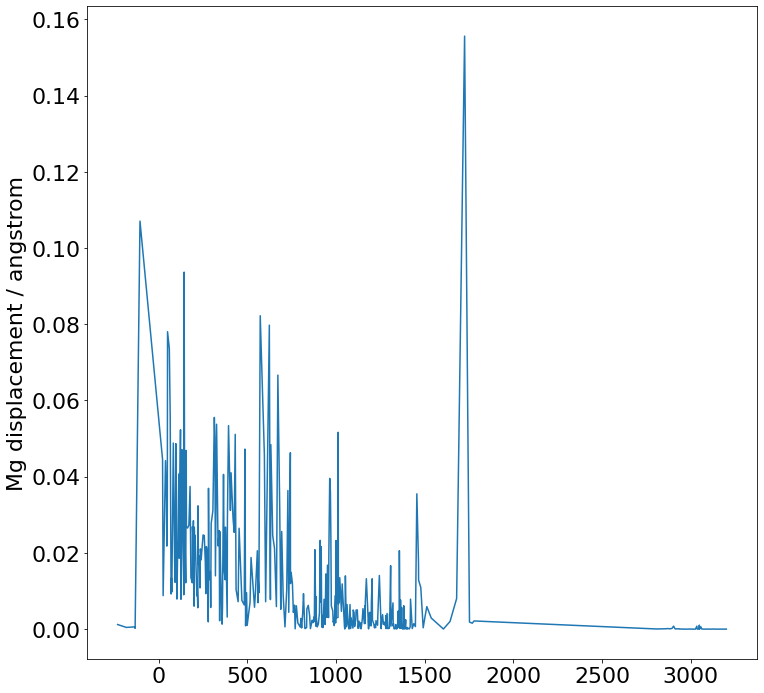

In [37]:
fig, ax = plt.subplots()

n_atoms = 140
n_modes = 3 * n_atoms - 6

Mg_index = 0

ax.plot(wavenumbers, all_displacements[23])

ax.set_ylabel("Mg displacement / angstrom")

fig.set_size_inches(12,12)

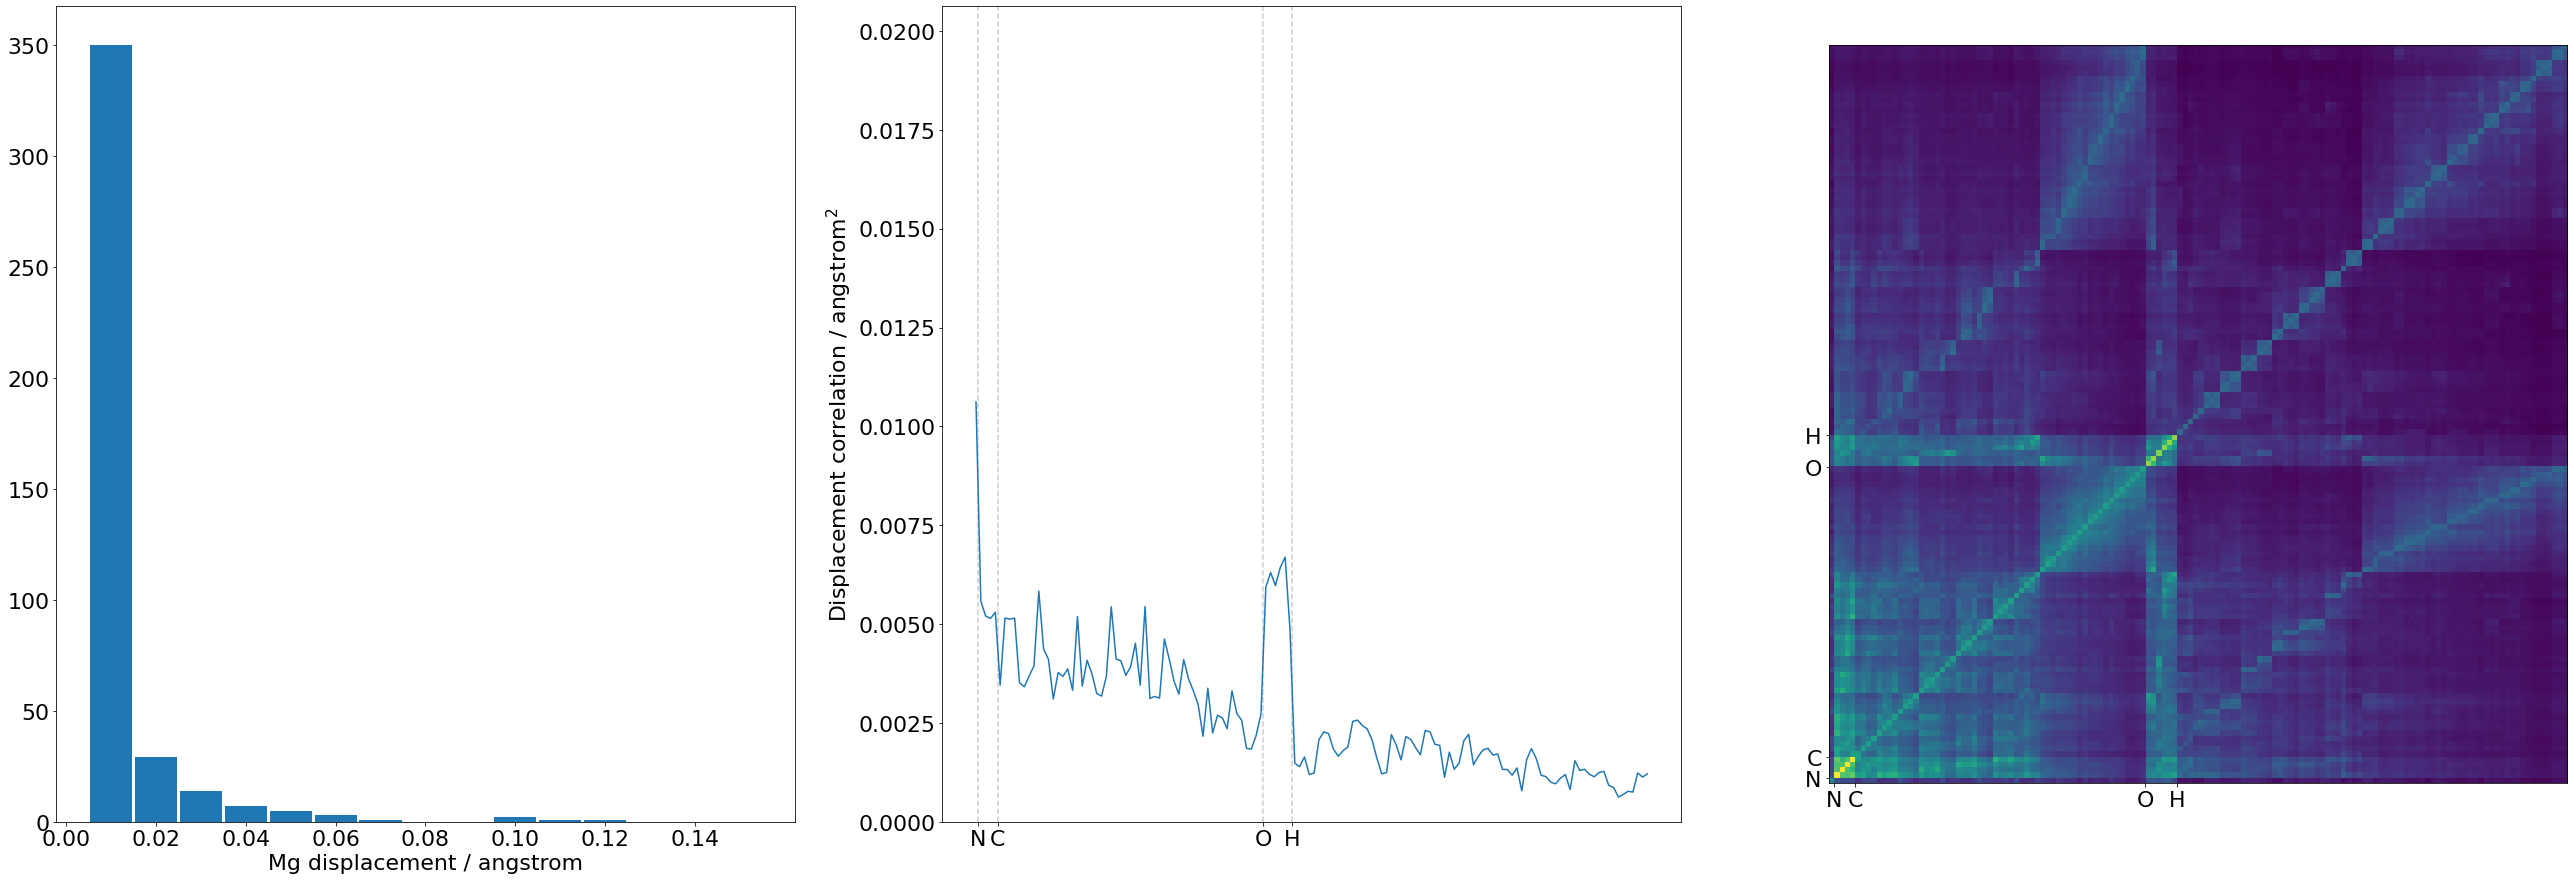

In [39]:
fig, ax = plt.subplots(1, 3)

symbols = read_symbols("../data/hessians/opt_bchla.xyz")

Mg_indices= get_indices(symbols, "Mg")
N_indices = get_indices(symbols, "N")
C_indices = get_indices(symbols, "C")
O_indices = get_indices(symbols, "O")
H_indices = get_indices(symbols, "H")

Mg_max_disp= all_displacements[Mg_indices].max()
N_max_disp = all_displacements[N_indices].max()
C_max_disp = all_displacements[C_indices].max()
O_max_disp = all_displacements[O_indices].max()
H_max_disp = all_displacements[H_indices].max()

normalized_displacements = copy.copy(all_displacements)

normalized_displacements[Mg_indices]/= Mg_max_disp
normalized_displacements[N_indices] /= N_max_disp
normalized_displacements[C_indices] /= C_max_disp
normalized_displacements[O_indices] /= O_max_disp
normalized_displacements[H_indices] /= H_max_disp

grouped_symbols = np.concatenate((Mg_indices, N_indices, C_indices, O_indices, H_indices))

normalized_displacements = normalized_displacements[grouped_symbols]

bins = np.linspace(0, 0.15, 16)
his = np.histogram(all_displacements[Mg_index], bins=bins)

ax[0].bar(his[1][1:], his[0], width=0.15/len(bins), align='center')
ax[0].set_xticks(bins[::2])

ax[0].set_xlabel("Mg displacement / angstrom")
ax[1].set_ylabel("Frequency")

Mg_displacements = np.where(all_displacements[Mg_index] > 0.0)[0]

correlation = np.zeros((n_atoms, n_atoms))

for i in Mg_displacements:
    correlation += np.outer(normalized_displacements[:,i], normalized_displacements[:,i])
    
correlation /= len(Mg_displacements)

cax = ax[2].imshow(correlation, origin='lower', cmap=plt.get_cmap('viridis'))#, norm=LogNorm(vmin=0.0001, vmax=20))
    
#fig.colorbar(cax)

def ticks(symbols):
    Mg_indices= get_indices(symbols, "Mg")
    N_indices = get_indices(symbols, "N")
    C_indices = get_indices(symbols, "C")
    O_indices = get_indices(symbols, "O")
    H_indices = get_indices(symbols, "H")
    
    lengths = [len(Mg_indices), len(N_indices), len(C_indices), len(O_indices), len(H_indices)]
    
    cumulative = np.cumsum(lengths)
    
    ticks = np.array([x - 0.5 for x in cumulative[:-1]])
    
    return ticks

# number of each element --  Mg: 1, N: 4, C: 55, O: 6, H: 74
# cumulative -- 1, 5, 39, 43, 79

symbol_ticks = ticks(symbols)
symbol_labels= ["N","C","O","H"]

ax[2].set_xticks(symbol_ticks)
ax[2].set_xticklabels(symbol_labels)

ax[2].set_yticks(symbol_ticks)
ax[2].set_yticklabels(symbol_labels)

ax[1].plot(correlation[0])
ax[1].set_xticks(symbol_ticks)
ax[1].set_xticklabels(symbol_labels)
ax[1].set_ylabel("Displacement correlation / $\mathrm{angstrom}^2$")

ax[1].vlines(symbol_ticks, color='black', linestyle='--', ymin=0, ymax=max(correlation[0])+0.01, alpha=0.2)
ax[1].set_ylim(0, max(correlation[0])+0.01)

fig.set_size_inches(45,15)

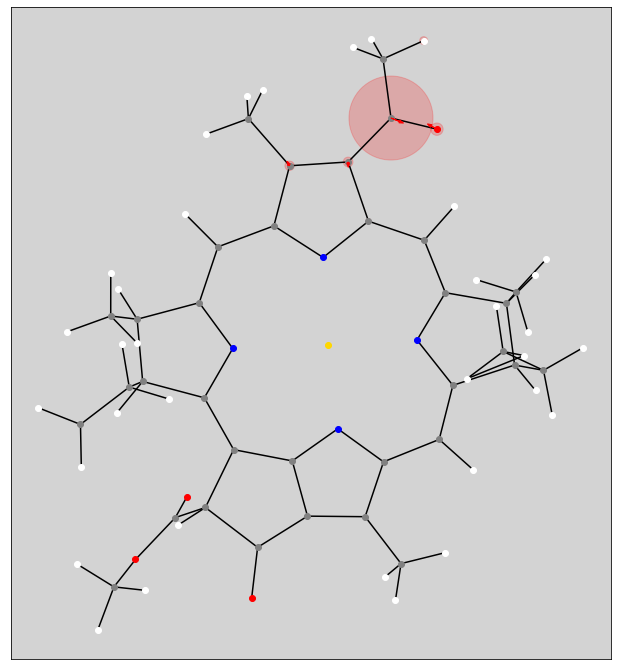

In [44]:
symbols = read_symbols("../data/hessians/opt_bchla.xyz")

bchla_in_xy_plane, rotation_matrix = get_bchla_in_xy_plane()

fig, ax = plt.subplots()

plot_molecule(bchla_in_xy_plane, symbols, ax)

max_mg_modes = np.argsort(Mg_displacements)[::-1]

for m in [336]:
    mode = normalized_displacements[:, m]    
    for n in range(140):
        if n in phytol_indices():
            continue
            
        circle = plt.Circle((bchla_in_xy_plane[n][0], bchla_in_xy_plane[n][1]), mode[n], color='r', alpha=0.2, zorder=0)
        ax.add_patch(circle)
                
        if mode[n] > 1e-1:
            disp_vec = np.matmul(rotation_matrix, np.array([all_coords[n][0][m], all_coords[n][1][m], all_coords[n][2][m]]))

            ax.arrow(bchla_in_xy_plane[n][0], bchla_in_xy_plane[n][1], disp_vec[1], disp_vec[2], head_width=0.07, color='red')
        
        

ax.set_yticks([])
ax.set_xticks([])
        
fig.set_size_inches(12,12)

In [31]:
1/wavenumber_to_frequency(1600)

20.8477559498845